In [3]:
from osgeo import gdal, osr
import numpy as np

In [4]:
from osgeo import gdal, osr
import numpy as np

In [27]:
# %cd /home/ayush12gupta/Desktop/ugp/exp2
%cd /DATA/glacier-vel/Automated_Offset_Tracking/

/DATA/glacier-vel/Automated_Offset_Tracking


In [28]:
ls

configs/           notebook/           README.md          stack/
data/              offset_batch.py     reference.xml      stack_process.py
docs/              offset_tracking.py  requirements.txt   topsApp.py*
geogrid_autorift/  preprocessing/      secondary.xml      topsApp.xml
isce_batch.py      __pycache__/        single_process.py  utils.py


In [ ]:
import pandas as pd


In [3]:
#-------------Get bbox ------------------------
def getbbox(filenm):
    ds = gdal.Open(filenm)
    geo = ds.GetGeoTransform()
    demsp = ds.GetRasterBand(1).ReadAsArray()
    x_size, y_size = demsp.shape[::-1]
    print(x_size, y_size)
    geo_t = np.array(geo).copy()
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
    return [xmin, ymin, xmax, ymax]

bbox = getbbox('velocity.tif')

# ------------Bbox cropping----------------------
# !gdalwarp -te 674777.4423958672 3549293.760153323 760890.8205813951 3628864.074188244 ../slope_demroi2.tif clippedByCoords.tif
# !gdalwarp -te 674777.4423958672 3549293.760153323 765825.8435424459 3628864.074188244 ../slope_demroi2.tif slope_dem.tif

3106 2870


In [17]:
def read_vals(fn, nodat=None, band=1):
    ds = gdal.Open(fn)
    disp = ds.GetRasterBand(band).ReadAsArray()
    nodata = np.isnan(disp)
    disp[nodata] = -32767
    if nodat is not None:
        nodata = (nodat|nodata)
        disp[nodat] = -32767
    ds = None
    return disp, nodata

In [22]:
val, nodata = read_vals('stack_0_1_1.tif')

In [24]:
val

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [2]:
import os
from osgeo import gdal
from osgeo import osr
import numpy

# config
GDAL_DATA_TYPE = gdal.GDT_Float64 
GEOTIFF_DRIVER_NAME = "GTiff"
NO_DATA = -32767
SPATIAL_REFERENCE_SYSTEM_WKID = 32767

def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):

    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path, int(columns), int(rows), nband, eType = gdal_data_type)    
    return output_raster

def numpy_array_to_raster(output_path,
                          numpy_array,
                          proj,
                          trans,
                          nband = 1,
                          no_data = NO_DATA,
                          gdal_data_type = GDAL_DATA_TYPE,
                          spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,
                          driver = GEOTIFF_DRIVER_NAME):


    rows, columns = numpy_array.shape
    output_raster = create_raster(output_path, int(columns), int(rows), nband, gdal_data_type) 
    geotransform = trans
    print(geotransform)

    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromWkt(proj)
    # spatial_reference.ImportFromProj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
    output_raster.SetProjection(spatial_reference.ExportToWkt())
    output_raster.SetGeoTransform(geotransform)
    output_band = output_raster.GetRasterBand(1)
    output_band.SetNoDataValue(no_data)
    output_band.WriteArray(numpy_array)          
    output_band.FlushCache()
    print(output_raster.GetProjection())
    
    return  output_raster

In [5]:
import netCDF4

file2read = netCDF4.Dataset('exp21_G0028V02_P095.nc','r')
print(file2read.variables.keys())
file2read['img_pair_info']
# er = np.array(file2read['v_error'])

# geo_tans = file2read['mapping'].GeoTransform.split(' ')
# geo_trans = [float(trans) for trans in geo_trans]
# geo_trans

odict_keys(['img_pair_info', 'x', 'y', 'mapping', 'vx', 'vy', 'v', 'v_error', 'vr', 'va', 'M11', 'M12', 'chip_size_width', 'chip_size_height', 'interp_mask'])


<class 'netCDF4._netCDF4.Variable'>
vlen img_pair_info()
    mission_img1: S
    sensor_img1: C
    satellite_img1: 1A
    acquisition_img1: 20190701T12:56:28.026977
    time_standard_img1: UTC
    absolute_orbit_number_img1: 027924
    mission_data_take_ID_img1: 03271C
    product_unique_ID_img1: 0046
    flight_direction_img1: ascending
    mission_img2: S
    sensor_img2: C
    satellite_img2: 1A
    acquisition_img2: 20190713T12:56:28.737528
    time_standard_img2: UTC
    absolute_orbit_number_img2: 028099
    mission_data_take_ID_img2: 032C6A
    product_unique_ID_img2: 869A
    flight_direction_img2: ascending
    date_dt: 12.000008223969907
    date_center: 20190707T12:56:28.382253
    latitude: 32.3
    longitude: 76.73
    roi_valid_percentage: 95.3
    autoRIFT_software_version: 1.4.0
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = ()

In [6]:
import netCDF4
#-----Params for velocity processing----------------
incidenceAngle = 41.8862
deg2rad = np.pi/180
sin_incid = np.sin(incidenceAngle*deg2rad)
cos_incid = np.cos(incidenceAngle*deg2rad)

#----------- Angle u-----------------------
demsp = gdal.Open('slope_dem.tif')
projs = demsp.GetProjection()
geo = demsp.GetGeoTransform()
nodata = demsp.GetRasterBand(1).GetNoDataValue()
angle_u = demsp.GetRasterBand(1).ReadAsArray()*deg2rad
angle_u_nodt = (angle_u==nodata)
demsp = None

#----------- Compute angle V------------------------
file2read = netCDF4.Dataset('exp21_G0028V02_P095.nc','r')

vr = np.array(file2read['vr']).astype(float)
vr_nodt = (vr==-32767)
vr[vr_nodt] = 0  #np.nan
va = np.array(file2read['va']).astype(float)
va_nodt = (va==-32767)
va[va_nodt] = 0  #np.nan

nodata = (va!=0)
tmp = np.zeros_like(vr)
tmp[nodata] = (vr*sin_incid)[nodata]/va[nodata]
angle_v = np.arctan(tmp)

In [9]:
# ds = gdal.Open('../slope_demroi.tif')

print(projs)
# demsp[demsp==-9999] = -32767
# # geo
# demsp.shape

PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]


In [24]:
#--------------Flow velocity along the glacier plane--------------------
vf = vr*(((np.cos(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.sin(angle_u))) + va*(np.cos(angle_u)*np.cos(angle_v))
vf[angle_u_nodt] = 0
vf[va_nodt] = -32767
vf[vr_nodt] = -32767

In [25]:
#------------Thickness change velocity------------------------
vn = vr*(((np.sin(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.cos(angle_u))) + va*(np.sin(angle_u)*np.cos(angle_v))
vn[angle_u_nodt] = 0
vn[va_nodt] = -32767
vn[vr_nodt] = -32767

In [26]:
vf[vf>0].max()

13446.361317888079

In [27]:
vn[vn>0].max()

11405.777317549413

In [11]:
va[va>0].mean()

147.36619343976068

In [35]:
output_path = 'dem_crp.tif'
ds = numpy_array_to_raster(output_path, data, projs, geo)
ds.FlushCache()
ds = None

(674777.4423958672, 27.724848095791327, 0.0, 3628864.074188244, 0.0, -27.72484809579133)
PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]


In [52]:
from pyproj import Proj, transform
def transfPoint(x1, y1):
    outProj = Proj(init='epsg:32643')
    inProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj,outProj,x1,y1)
    return x2, y2
# print(transfPoint(674777.4423958672, 3549293.760153323))

In [62]:
def map_to_pixel(mx,my,gt):
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - gt[0]) / gt[1]) #x pixel
    py = int((my - gt[3]) / gt[5]) #y pixel

    return px,py

def extent_to_offset(xmin,ymin,xmax,ymax,gt):
    pxmin,pymin = map_to_pixel(xmin,ymin,gt)
    pxmax,pymax = map_to_pixel(xmax,ymax,gt)
    print(pxmin, pymin, pxmax, pymax)
    return pxmin,pymin,pxmax-pxmin,pymax-pymin

In [63]:
# (np.array(val)*100)/365
ds = gdal.Open('Vf.tif')
projs = ds.GetProjection()
geo = ds.GetGeoTransform()
xoff, yoff, xsize, ysize = extent_to_offset(x1,y1,x2,y2,geo)
print(xoff, yoff, xsize, ysize)

1705 2056 1706 2056
1705 2056 1 0


In [83]:
import xarray as xr

# We define a location
lon1, lat1 = (77.3575, 32.2614)
lon2, lat2 = (77.3576, 32.2615)
# 32.2538N/77.3596E 32.2509N/77.3616E 5.30
x1, y1 = transfPoint(lon1, lat1)
x2, y2 = transfPoint(lon2, lat2)

print(x1, y1, x2, y2)

# In this example I am reading a file with (time, x, y) as dimensions
xarr = xr.open_rasterio('Vf.tif')

# Slice one of the bands
img = xarr[0, :, :]
# img
#Use the .sel() method to retrieve the value of the nearest cell close to your POI
val = img.sel(x=x2, y=y2, method="nearest")    
print("This is val: ", val)
val = img.sel(x=x1, y=y1, method="nearest")    
print("This is val: ", val)

722071.560912495 3571850.044141498 722080.7393134453 3571861.3399736956
This is val:  <xarray.DataArray ()>
array(-53.88326)
Coordinates:
    band     int64 1
    y        float64 3.572e+06
    x        float64 7.221e+05
Attributes:
    transform:      (27.724848095791327, 0.0, 674777.4423958672, 0.0, -27.724...
    crs:            +proj=utm +zone=43 +datum=WGS84 +units=m +no_defs=True
    res:            (27.724848095791327, 27.72484809579133)
    is_tiled:       0
    nodatavals:     (-32767.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
This is val:  <xarray.DataArray ()>
array(16.813273)
Coordinates:
    band     int64 1
    y        float64 3.572e+06
    x        float64 7.221e+05
Attributes:
    transform:      (27.724848095791327, 0.0, 674777.4423958672, 0.0, -27.724...
    crs:            +proj=utm +zone=43 +datum=WGS84 +units=m +no_defs=True
    res:            (27.724848095791327, 27.72484809579133)
    is_tiled:       0
    nodatavals:    

In [27]:
inv_geotransform = gdal.InvGeoTransform(geo)

bbox = [x1, y1, x2, y2]

_x0, _y0 = gdal.ApplyGeoTransform(inv_geotransform, bbox[0], bbox[1])
_x1, _y1 = gdal.ApplyGeoTransform(inv_geotransform, bbox[2], bbox[3])

print(_x0, _y0, _x1, _y1)

x0, y0 = min(_x0, _x1), min(_y0, _y1)
x1, y1 = max(_x0, _x1), max(_y0, _y1)

print(int(x0), int(y0), int(x1-x0), int(y1-y0))

-24335.820636980414 130888.51060100606 -24335.82063698038 130888.51060100603
-24335 130888 0 0


In [34]:
# (np.array(val)*100)/365
ds = gdal.Open('slope_dem.tif')
band = ds.GetRasterBand(1)
data = band.ReadAsArray()
data[va_nodt] = -32767

In [13]:
# data[data>0].max()
# va_nodt
38/365

0.10410958904109589

In [5]:
# Combine
ds = gdal.Open('Vf.tif')
vf = ds.GetRasterBand(1).ReadAsArray()
ds = gdal.Open('Vn.tif')
vn = ds.GetRasterBand(1).ReadAsArray()
# v = np.sqrt(vn**2 + vf**2)
vf_u = vf[vf!=-32767]
vn_u = vn[vn!=-32767]

print(vf_u[vf_u<150].mean(), vn_u[vn_u<150].mean())
print(vf_u.std(), vn_u.std())

-64.26200262342863 -21.53390444782821
746.3834765581355 292.5115292117991


In [15]:
vf[vf==-32767] = np.nan
vn[vn==-32767] = np.nan
print(vf[vf<200].mean(), vn[vn<200].mean())
print(vf.std(), vn.std())


-60.97274070628989 -20.252527209442224
nan nan


In [20]:
data[data==np.nan] = 0
Q1 = np.median(data)
  
# Third quartile (Q3)
Q3 = np.median(data)
  
# Interquartile range (IQR)
IQR = Q3 - Q1
  
print(IQR)

nan


(8914220,) nan nan nan


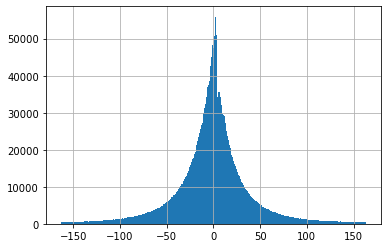

In [17]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations

data = vn[vn!=np.nan]
print(data.shape, data.min(), data.max(), data.std())

plt.hist(data, bins=1000, range=[-163,163])
plt.grid()

plt.show()

(8914220,) nan nan nan


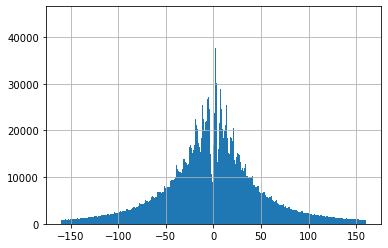

In [18]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations

data = vf[vf!=np.nan]
print(data.shape, data.min(), data.max(), data.std())

plt.hist(data, bins=1000, range=[-160,160])
plt.grid()

plt.show()

In [1]:
from osgeo import gdal, osr
import numpy as np

In [23]:
np.percentile(vf[vf<200], 95)

97.62949870094214